In [1]:
%matplotlib widget
import sep
import config
from f_utils import *
from models.networks import *
from utils.common_utils import *
from utils.inpainting_utils import * 
import torch.optim
import torch.nn.functional as F
from utils2 import scale_v, Sobolev_loss
from stdpipe import templates
from astropy.coordinates import SkyCoord, Angle
from astropy import units as u
from PIL import Image, ImageDraw, ImageFont
from astropy.visualization import ZScaleInterval
from torch.autograd import Variable
from sklearn.linear_model import LinearRegression
from scipy.optimize import minimize_scalar
from scipy.interpolate import griddata
from photutils.detection import DAOStarFinder
from photutils.psf import PSFPhotometry, IntegratedGaussianPRF
from photutils.background import Background2D, MedianBackground
from photutils.segmentation import make_2dgaussian_kernel, detect_sources
from astropy.convolution import convolve
from astropy.stats import sigma_clipped_stats
from astropy.visualization import simple_norm
from photutils.centroids import centroid_quadratic
from photutils.profiles import RadialProfile
from sklearn.metrics import r2_score as r2
import matplotlib.colors as mcolors
import glob
import imageio
import imageio.v2 as iio
import pandas as pd
from astropy.table import QTable
from photutils.psf import PSFPhotometry
from config_params import config1, config2, config3, config4, config5, config6, config7, config8, config9, config10, config11, config12
from photutils.datasets import make_gaussian_sources_image
from photutils.background import LocalBackground, MMMBackground
from photutils.aperture import aperture_photometry
from photutils.aperture import CircularAperture


torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark =True

Minimum value:  1.705780445775116e-16
Values of variables:  [0.99999999 1.99999999]
Could not import regions, which is required for some of the functionalities of this module.


## Data

In [2]:
#data
# a = 128
# fl = os.listdir('./datasets/a2b/train/')
# i = np.random.randint(0, len(fl))
# print(fl[i])
# d = np.loadtxt('./datasets/a2b/train/' + fl[i])
# sci_d = d[:, :512]
# ref_d = d[:, 512:]

# 221009
# sci_d = get_d('./sci.fits')[512-a:512+a, 512-a:512+a]
# ref_d = fixpix(get_d('./ref.fits')[512-a:512+a, 512-a:512+a])

# 171205
# sci_d = get_d('./sci2.fits')[512-a:512+a, 512-a:512+a]
# ref_d = fixpix(get_d('./ref2.fits')[512-a:512+a, 512-a:512+a])

# sci_d = oversample(sci_d, 2)
# ref_d = oversample(ref_d, 2)

# 171205 peak
x = 261.02
y = 241.68

# 231115
# sci_d = oversample(get_d('M82.fits'), 2)

# M82
sci_d = get_d('M82.fits')
ref_d = get_d('M82_ps.fits')

# lmbd1 = 2
# xmax1 = 64774
# mean1 = 6900
# sci_d = np.arcsinh((d1 - mean1) / lmbd1) / np.arcsinh(xmax1 / lmbd1)

# lmbd2 = 2
# xmax2 = 98303
# mean2 = 40300
# ref_d = np.arcsinh((d2 - mean2) / lmbd2) / np.arcsinh(xmax2 / lmbd1)

# sci_d[sci_d > 1] = 0
# ref_d[ref_d > 1] = 0

# sci_d = get_d('./sci3.fits')
# ref_d = get_d('./ref3.fits')

# Losses
mse = torch.nn.MSELoss()
# plt.rcParams.update({'font.size': 25})

In [3]:
def draw_plot(config, N_samples, n):
    fluxes = []

    # PSF fluxes
    psf_fluxes = []
    psf_fluxes_err = []

    # aperture fluxes
    ap_fluxes = []

    k = 0
    while k < N_samples:
        try:
            # new image with a probe source 
            sci_d_t, x, y, flux, transient = add_transient(sci_d, fwhm=10, flux_range='M82_fluxes.txt')
            profile = False
            
            # stretched
            ref_s, xmax_i, lmbd_i = stretch(ref_d, return_params=True, scale_lmbd=22)
            sci_s, xmax_t, lmbd_t = stretch(sci_d_t, return_params=True, scale_lmbd=.25)
        
            # wcs
            sci_wcs = WCS(get_h('M82.fits'))
            ref_wcs = WCS(get_h('M82_ps.fits'))
        
            a_t = 512
            sci_crop = sci_s[y - a_t // 2: y + a_t // 2, x - a_t // 2: x + a_t // 2]
            transient = transient[y - a_t // 2: y + a_t // 2, x - a_t // 2: x + a_t // 2]
            
            x_i, y_i = world2pix(ref_wcs, pix2world(sci_wcs, np.array([[x, y]])))[0]
            a_i = a_t
            
            ad = torch.nn.AdaptiveAvgPool2d(sci_crop.shape)
            ref_crop = ref_s[int(y_i - a_i // 2):int(y_i + a_i // 2), int(x_i - a_i // 2):int(x_i + a_i // 2)]
            ref_crop = torch2np(ad(np2torch(ref_crop)))
        
            # subtraction
            _, net = subtract_region(ref_crop, xmax_i, lmbd_i, 
                                              sci_crop, xmax_t, lmbd_t, 
                                              a_t / 2, a_t / 2, config)
            # difference image
            difference = unstretch(sci_crop, xmax_t, lmbd_t) - net.predict(ref_crop)
            
            # visualization
            png(np2torch(difference), path='./images/subtraction/', k=k)

            # psf photometry
            psf_flux, psf_measure = measure_flux(difference, a_t / 2, a_t / 2, method='psf', psf_size=31)
            psf_fluxes.append(psf_flux)
            psf_fluxes_err.append(psf_measure.flux_err.item())

            # aperture photometry
            ap_flux, ap_measure = measure_flux(difference, a_t / 2, a_t / 2, method='aperture', ap_r=12)
            ap_fluxes.append(ap_flux)
            
            # modeled flux
            fluxes.append(flux)
            
            k += 1
        except RuntimeError:
            print('Runtimerror')
            pass
            
    try:
        os.mkdir('configs/' + str(n))
    except FileExistsError:
        pass

    # saving flux history
    psf_fluxes = np.array(psf_fluxes) 
    psf_fluxes_err = np.array(psf_fluxes_err)
    ap_fluxes = np.array(ap_fluxes) 
    
    fluxes = np.array(fluxes) 
    sorted = np.argsort(fluxes)
    
    fluxes = fluxes[sorted][:-2]
    psf_fluxes = psf_fluxes[sorted][:-2]
    psf_fluxes_err = psf_fluxes_err[sorted][:-2]
    ap_fluxes = ap_fluxes[sorted][:-2]
    
    np.savetxt('configs/' + str(n) + '/' + 'fluxes.txt', fluxes)
    np.savetxt('configs/' + str(n) + '/' + 'psf_fluxes.txt', psf_fluxes)
    np.savetxt('configs/' + str(n) + '/' + 'psf_fluxes_err.txt', psf_fluxes_err)
    np.savetxt('configs/' + str(n) + '/' + 'ap_fluxes.txt', ap_fluxes)
    
    # visualization
    fig, ax = plt.subplots(figsize=(12, 12))
    plt.rcParams.update({'font.size': 25})
    
    colors = list(mcolors.TABLEAU_COLORS)
    # label = config.UPSAMPLE_MODE + '_skip_' + str(config.SKIP) + '_' + str(config.N_LAYERS_G) + '_' + str(config.KERNEL)
    
    ax.errorbar(fluxes, psf_fluxes, yerr=psf_fluxes_err,
                ls="",
                marker="o",
                markersize=15,
                color='darkgrey',
                label='PSF phot.',
                markerfacecolor=colors[0],
                markeredgecolor='k',
                markeredgewidth=1)

    ax.errorbar(fluxes, ap_fluxes,
                ls="",
                marker="o",
                markersize=15,
                color='darkgrey',
                label='aperture phot.',
                markerfacecolor=colors[1],
                markeredgecolor='k',
                markeredgewidth=1)
    
    maxflux = max(max(fluxes), max(psf_fluxes), max(ap_fluxes)) + 10
    linear = np.arange(0, maxflux, 100)
    
    psf_det_c = np.round(r2(psf_fluxes, fluxes), 3)
    ap_det_c = np.round(r2(ap_fluxes, fluxes), 3)
    
    ax.plot(linear, linear, color='k', lw=.5, label='y=x')
    
    ax.text(.145, .7, f'R2: {psf_det_c}', fontsize=25, color=colors[0], transform=ax.transAxes)
    ax.text(.145, .65, f'R2: {ap_det_c}', fontsize=25, color=colors[1], transform=ax.transAxes)
    ax.legend(fontsize=25, loc ="upper left")
    
    ax.set_xlim(10, maxflux)
    ax.set_ylim(10, maxflux)
    ax.set_xlabel('Modeled flux, ADUs', fontsize=25, labelpad=25)
    ax.set_ylabel('Estimated flux, ADUs', fontsize=25, labelpad=10)
    ax.grid()
    plt.savefig('configs/' + str(n) + '/' + 'plot.png')
    plt.close("all")

In [5]:
# draw_plot(config10, 50, 10)

In [8]:
# draw_plot(config8, 50, 8)

In [10]:
# draw_plot(config3, 50, 3)

In [11]:
# draw_plot(config4, 50, 4)

In [8]:
# draw_plot(config5, 100, 5)

In [9]:
# draw_plot(config6, 100, 6)

In [10]:
# draw_plot(config7, 100, 7)

In [40]:
# draw_plot(config8, 100, 8)

In [41]:
# draw_plot(config9, 100, 9)

In [42]:
# draw_plot(config10, 100, 10)

In [26]:
# draw_plot(config11, 100, 11)

In [27]:
# draw_plot(config12, 100, 12)

In [6]:
i = 1
config_text = make_text(config1)
modeled = np.loadtxt('./configs/' + str(i) + '/' + 'fluxes.txt')
measured = np.loadtxt('./configs/' + str(i) + '/' + 'psf_fluxes.txt')

fig, ax = plt.subplots(figsize=(12, 12))
plt.rcParams.update({'font.size': 25})

colors = list(mcolors.TABLEAU_COLORS)

ax.errorbar(modeled, measured,
            ls="",
            marker="o",
            markersize=15,
            color='darkgrey',
            markerfacecolor=colors[i-1],
            markeredgecolor='k',
            markeredgewidth=1.5)

maxflux = max(max(modeled), max(measured)) + 25
linear = np.arange(0, maxflux + 100, 100)

det_c = np.round(r2(measured, modeled), 3)

ax.plot(linear, linear, color='k', lw=.5, label='y=x')

ax.text(.03, .42, f'R2: {det_c}', fontsize=21, color='k', transform=ax.transAxes, weight='bold')
ax.text(.03, .45, config_text, fontsize=21, color='k', transform=ax.transAxes)

ax.legend(fontsize=25, loc ="upper left")

ax.set_xlim(10, maxflux)
ax.set_ylim(10, maxflux)

ax.set_xlabel('Modeled flux, ADUs', fontsize=25, labelpad=25)
ax.set_ylabel('Estimated flux, ADUs', fontsize=25, labelpad=12)

ax.grid()
plt.savefig('paper_images/5_' + str(i) + '.png')
plt.close("all")

In [ ]:
import torch

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
N_LAYERS_G = 7
NGF = 8 
KERNEL = 4 
SKIP = True
SKIP_MODE = 'mult'
UPSAMPLE_MODE = 'upscale' 
UPSCALE_MODE = 'area'
R = 16
PRETRAINED = None
PRETRAIN = False
DROPOUT = 1e-3
REGULARIZATION = 1e-3

N_ITERS = 401 
ITER_START_DECAY = 400  
LR = 1e-3

VISUALISE = 'None' 
PROFILE = False
ANIMATION = False
GIF = False

560 460


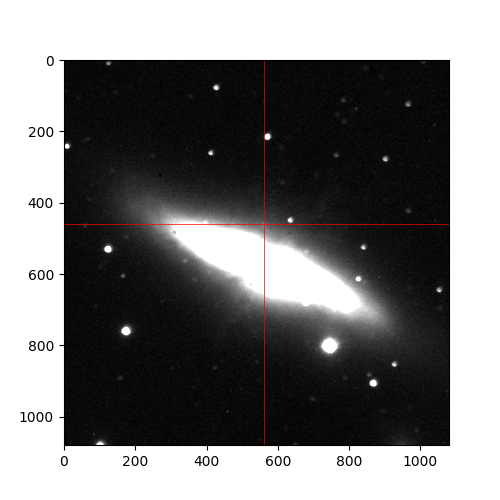

In [12]:
sci_d_t, x, y, flux, transient = add_transient(sci_d, fwhm=10, lb=2, flux_range='M82_fluxes.txt')

image_d(sci_d_t, ws=5, contrast=.1)
print(x, y)

plt.axvline(x, lw=.5, color='r')
plt.axhline(y, lw=.5, color='r')

In [13]:
ref_s, xmax_i, lmbd_i = stretch(ref_d, return_params=True, scale_lmbd=6.5)
sci_s, xmax_t, lmbd_t = stretch(sci_d_t, return_params=True, scale_lmbd=.12)

In [14]:
# fig, ax = plt.subplots(figsize=(12, 12))

# a,b,c = ax.hist(ref_s.ravel(), bins=200, label='Pan-STARRS (R)', 
#                 color='C1', histtype='stepfilled', edgecolor='k', lw=.75, density=True)

# a,b,c = ax.hist(sci_s.ravel(), bins=200, label='AC-32 AbAO (r)', 
#                 color='C0', hatch='///', histtype = 'step', fill=None, lw=1.5, density=True)

# plt.grid()
# plt.legend()
# ax.set_ylim(0.05, 5)
# ax.set_xlabel('Pixel value', labelpad=25)
# ax.set_ylabel('Density', labelpad=25)
# plt.savefig('stretched_data.png')
# plt.show()

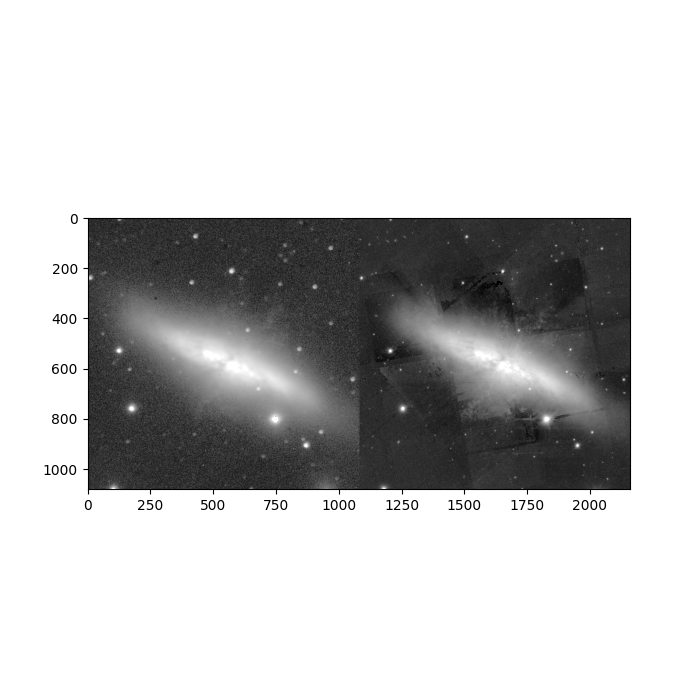

In [15]:
# visualization
size = int(sci_d.shape[0])
ad1 = torch.nn.AdaptiveAvgPool2d(sci_s.shape)
image_d(np.concatenate((sci_s, torch2np(ad1(np2torch(ref_s)))), 1), ws=7)

In [16]:
sci_wcs = WCS(get_h('M82.fits'))
ref_wcs = WCS(get_h('M82_ps.fits'))

(768, 768) (768, 768)


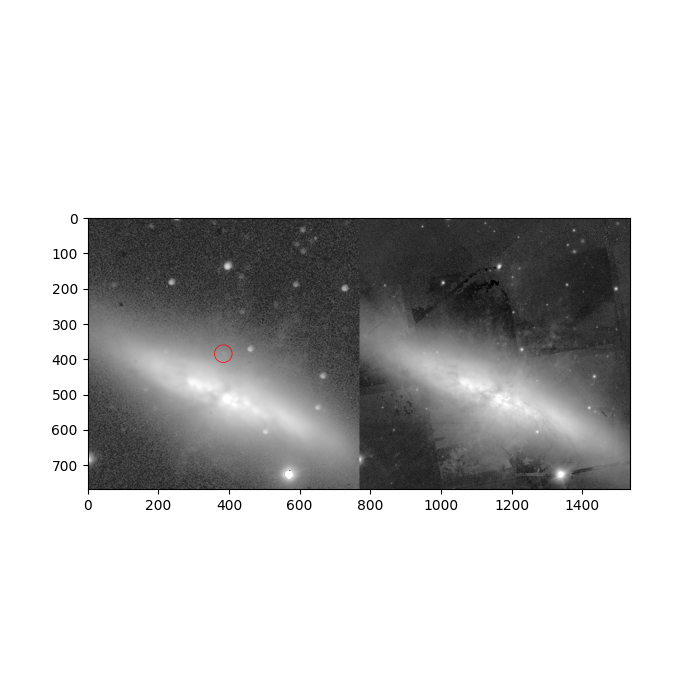

In [17]:
# sci crop
x_t = x 
y_t = y
a_t = 768
sci_crop = sci_s[y_t - a_t // 2: y_t + a_t // 2, x_t - a_t // 2: x_t + a_t // 2]
transient = transient[y_t - a_t // 2: y_t + a_t // 2, x_t - a_t // 2: x_t + a_t // 2]

# ad0 = torch.nn.AdaptiveAvgPool2d((768, 768))
# sci_crop = torch2np(ad0(np2torch(sci_crop)))

# ref_crop
x_i, y_i = world2pix(ref_wcs, pix2world(sci_wcs, np.array([[x_t, y_t]])))[0]
# a_i = int(a_t * 0.65 / 0.25)
a_i = a_t

# adaptive layer
ad = torch.nn.AdaptiveAvgPool2d(sci_crop.shape)
ref_crop = ref_s[int(y_i - a_i // 2):int(y_i + a_i // 2), int(x_i - a_i // 2):int(x_i + a_i // 2)]
# ref_crop = ref_s
ref_crop = torch2np(ad(np2torch(ref_crop)))

# ref_crop = np.random.normal(0, 0.1, (256, 256))

fig, ax = plt.subplots(figsize=(7, 7))
image = np.concatenate((sci_crop, ref_crop), 1)
vmin, vmax = get_contrast(image, .25)

ax.imshow(image, vmin=vmin, vmax=vmax, cmap='gray')

circle = plt.Circle((a_t / 2, a_t / 2), 25, color='r', fill=False, 
                    linestyle='-', label='Simulated transient', lw=.5)

# ax.tick_params(labelleft=True, left=True)
ax.add_patch(circle)
# ax.legend()

print(sci_crop.shape, ref_crop.shape)
# plt.savefig('./paper_images/0.png')

In [258]:
# fig, ax = plt.subplots(figsize=(12, 12))

# image = np.concatenate((sci_crop, ref_crop), 1)
# vmin, vmax = get_contrast(image, .25)

# circle = plt.Circle((a_t / 2, a_t / 2), 25, color='r', fill=False, 
#                     linestyle='-', label='Simulated transient', lw=1)

# ax.add_patch(circle)

# ax.legend(loc='upper left')
# ax.imshow(ref_crop, vmin=vmin, vmax=vmax, cmap='gray')
# plt.savefig('./paper_images/fig3_12.png')

In [259]:
# fig, ax = plt.subplots(figsize=(12, 12))
# ax.imshow(1 - torch2np(net.mask), cmap='gray')
# plt.savefig('./paper_images/fig3_21.png')

In [260]:
# im1 = np.concatenate((sci_crop, ref_crop), 1)
# im2 = np.concatenate((torch2np(net.mask), ref_crop), 1)

In [261]:
# fig, ax = plt.subplots(figsize=(5,5))
# ax.imshow(torch2np(1 - net.mask), cmap='gray')
# plt.savefig('./paper_images/2.png')

In [135]:
config.N_LAYERS_G = 7
config.NGF = 8
config.KERNEL = 6
config.SKIP = True
config.SKIP_MODE = 'concat'
config.UPSAMPLE_MODE = 'upscale' 
config.UPSCALE_MODE = 'area'
config.DROPOUT = 0
config.R = 100
config.PRETRAINED = None
config.PRETRAIN = True

config.N_ITERS = 401 
config.ITER_START_DECAY = config.N_ITERS - 1
config.LR = 1e-3
config.REGULARIZATION = 0

config.VISUALISE = 'None'
config.PROFILE = False
config.GIF = False

In [136]:
%%time
difference, net = subtract_region(ref_crop, xmax_i, lmbd_i, 
                    sci_crop, xmax_t, lmbd_t, 
                    a_t / 2 + 32, a_t / 2 - 32, config)

SKYNET is chosen
initialize network with normal


Strating pretraining
Starting optimization with ADAM
Iteration 01000    Loss 0.028215 

Pretraining is finished
Number of params: 1.528 M


Starting inpainting
Starting optimization with ADAM
CPU times: total: 1min 50s023702 
Wall time: 2min 17s


In [137]:
difference = unstretch(sci_crop, xmax_t, lmbd_t) - net.predict(ref_crop)

Text(0.02, 0.7, 'r: 100\nmethod: upscale\nmode: "area"\nskip: True\nskip_mode: concat\nlayers: 7\nfilters: 8\nkernel: 6\nL2 penalty: 0\ndropout: 0\niters: 400\nlr: 0.001\n')

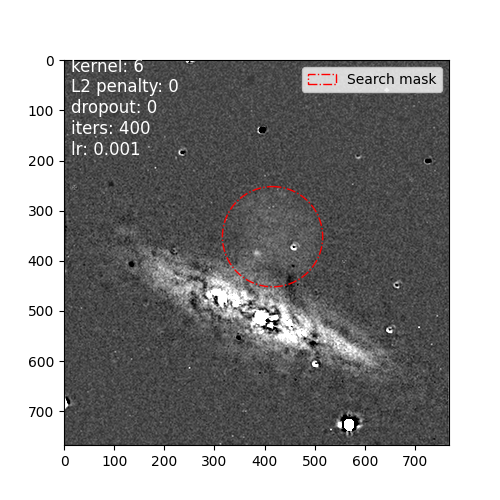

In [138]:
fig, ax = plt.subplots(figsize=(5, 5))
# plt.rcParams.update({'font.size': 12})

ax.imshow(difference, vmin=-10, vmax=25, cmap='gray')

circle2 = plt.Circle((a_t / 2 + 32 , a_t / 2 - 32), config.R, color='r', fill=False, 
                    linestyle='-.', label='Search mask', lw=1)

ax.add_patch(circle2)
ax.legend()

text = make_text(config)
ax.text(.02, .7, text, fontsize=12, transform=ax.transAxes, color='w')
# plt.savefig('./paper_images/fig4_5.png')

In [139]:
psf_flux, _ = measure_flux(difference, a_t / 2, a_t / 2, method='psf', ap_r=12)
aperture_flux, _ = measure_flux(difference, a_t / 2, a_t / 2, method='aperture', ap_r=12)

In [140]:
print(f'Modeled: {flux}')
print(f'Measured: {psf_flux}')
print(f'Measured: {aperture_flux}')

Modeled: 1760.4307098496308
Measured: 1747.9407302116588
Measured: 3183.9086472987055


In [63]:
x = 290
y = 985

# psf_model = IntegratedGaussianPRF(flux=1, sigma=10 / 2.35)
# psf_shape = (21, 21)
# nsources = 1
# shape = (101, 101)
# new_sci_d, params = make_test_psf_data(shape, psf_model, psf_shape,
#                                        nsources, flux_range=(500, 700), seed=0)

m = np.median(np.loadtxt('M82_fluxes.txt'))
flux = m * (2 + 5 * np.random.random()) 
print(flux)

table = QTable()
table['flux'] = [flux]
table['x_mean'] = [x]
table['y_mean'] = [y]
table['x_stddev'] = [10 / 2.355]
table['y_stddev'] = [10 / 2.355]

star = make_gaussian_sources_image(sci_d.shape, table)
new_sci_d = sci_d + star 

# print(params['x'].item())
# print(params['y'].item())
# print(params['flux'].item())

1876.0201905765127


In [69]:
measurement = measure_flux(new_sci_d, x, y, ap_r=20)
measured_f = measurement['aperture_sum'].item()

print(f'Modeled: {flux}')
print(f'Measured: {measured_f}')

Modeled: 1876.0201905765127
Measured: 1862.7492091805773


In [4]:
diff_fluxes = np.array(diff_fluxes) 
fluxes = np.array(fluxes) 

fluxes = fluxes[np.argsort(fluxes)][:-1]
diff_fluxes = diff_fluxes[np.argsort(diff_fluxes)][:-1]

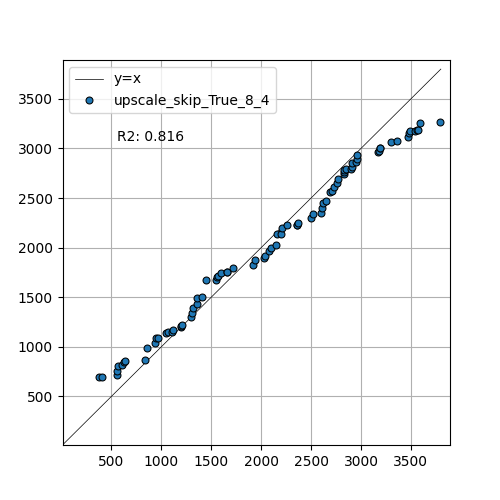

In [22]:
fig, ax = plt.subplots(figsize=(5, 5))

colors = list(mcolors.TABLEAU_COLORS)
label = config.UPSAMPLE_MODE + '_skip_' + str(config.SKIP) + '_' + str(config.N_LAYERS_G) + '_' + str(config.KERNEL)

ax.errorbar(diff_fluxes, fluxes,
            ls="",
            marker="o",
            markersize=5,
            color='darkgrey',
            label=label,
            markerfacecolor=colors[0],
            markeredgecolor='k',
            markeredgewidth=.75)

maxflux = max(max(fluxes), max(diff_fluxes)) + 100
linear = np.arange(0, maxflux, 100)
det_c = np.round(r2(diff_fluxes, fluxes), 3)

ax.plot(linear, linear, color='k', lw=.5, label='y=x')
ax.text(.14, .79, f'R2: {det_c}', fontsize=10, color='k', transform=ax.transAxes)
ax.legend()

ax.set_xlim(10, maxflux)
ax.set_ylim(10, maxflux)
ax.grid()
plt.close("all")

In [24]:
np.median(np.loadtxt('M82_fluxes.txt'))

571.826171875

(1000.0, 4589.203390321851)

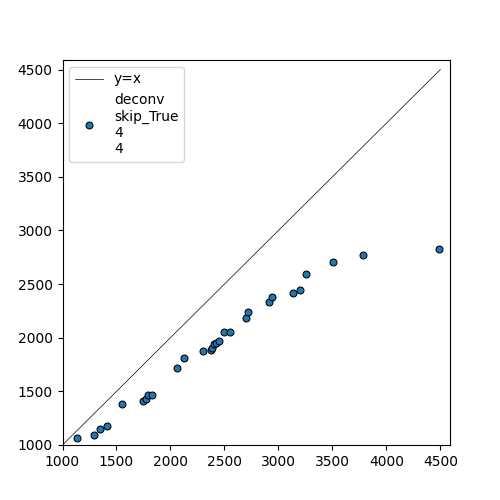

In [12]:
fig, ax = plt.subplots(figsize=(5, 5))

colors = list(mcolors.TABLEAU_COLORS)
label = config.UPSAMPLE_MODE + '\n' + 'skip_' + str(config.SKIP) + '\n' + str(config.N_LAYERS_G) + '\n' + str(config.KERNEL)

ax.errorbar(diff_fluxes, fluxes,
            ls="",
            marker="o",
            markersize=5,
            color='darkgrey',
            label=label,
            markerfacecolor=colors[0],
            markeredgecolor='k',
            markeredgewidth=.75)

maxflux = max(max(fluxes), max(diff_fluxes)) + 100
linear = np.arange(0, maxflux, 100)

ax.plot(linear, linear, color='k', lw=.5, label='y=x')
ax.legend()

ax.set_xlim(1000, maxflux)
ax.set_ylim(1000, maxflux)

In [61]:
fluxes

array([1210.94615534, 1665.83963949, 1709.09991576, 1758.82108181,
       1942.89390013, 2137.07117069])

231115

In [27]:
xs = [240, 240, 250, 230, 250, 240, 190]
ys = [265, 260, 280, 280, 270, 280, 250]
r = 16

masks = []

for k in range(7):
    masks.append(make_mask(sci_d, xs[k], ys[k], r))

In [28]:
# %matplotlib ipympl
# for k in range(7):
#     image_d(sci_d * masks[k], ws=5)

In [29]:
net1 = define_G(n_layers_G=7, ngf=32, kernel=4, skip=True, upsample_mode='deconv', upscale_mode='nearest')
net2 = define_G(n_layers_G=7, ngf=8, kernel=4, skip=True, upsample_mode='upscale', upscale_mode='nearest')
net3 = define_G(n_layers_G=7, ngf=8, kernel=4, skip=True, upsample_mode='upscale', upscale_mode='nearest')
net4 = define_G(n_layers_G=7, ngf=8, kernel=4, skip=True, upsample_mode='upscale', upscale_mode='nearest')
net5 = define_G(n_layers_G=7, ngf=8, kernel=4, skip=True, upsample_mode='upscale', upscale_mode='nearest')
net6 = define_G(n_layers_G=7, ngf=8, kernel=4, skip=True, upsample_mode='upscale', upscale_mode='nearest')
net7 = define_G(n_layers_G=7, ngf=8, kernel=4, skip=True, upsample_mode='upscale', upscale_mode='nearest')

SKYNET is chosen
initialize network with normal
SKYNET is chosen
initialize network with normal
SKYNET is chosen
initialize network with normal
SKYNET is chosen
initialize network with normal
SKYNET is chosen
initialize network with normal
SKYNET is chosen
initialize network with normal
SKYNET is chosen
initialize network with normal


In [30]:
ip1 = Inpainter(net1, mse, n_iters=1001, iter_start_decay=200, lr=2e-4, 
               visualize='subtraction', profile=False, x=xs[0], y=ys[0], r=r)

ip2 = Inpainter(net2, mse, n_iters=1002, iter_start_decay=200, lr=1e-3, 
               visualize='subtraction', profile=False, x=xs[1], y=ys[1], r=r)

ip3 = Inpainter(net3, mse, n_iters=1003, iter_start_decay=200, lr=1e-3, 
               visualize='subtraction', profile=False, x=xs[2], y=ys[2], r=r)

ip4 = Inpainter(net4, mse, n_iters=1004, iter_start_decay=200, lr=1e-3, 
            visualize='subtraction', profile=False, x=xs[3], y=ys[3], r=r)

ip5 = Inpainter(net5, mse, n_iters=1005, iter_start_decay=200, lr=1e-3, 
               visualize='subtraction', profile=False, x=xs[4], y=ys[4], r=r)

ip6 = Inpainter(net6, mse, n_iters=1006, iter_start_decay=200, lr=1e-3, 
                visualize='subtraction', profile=False, x=xs[5], y=ys[5], r=r)

ip7 = Inpainter(net7, mse, n_iters=1007, iter_start_decay=200, lr=1e-3, 
               visualize='subtraction', profile=False, x=xs[6], y=ys[6], r=r)

In [31]:
ip1.fit(ref_d, sci_d, masks[0])
# ip2.fit(ref_d, sci_d, masks[1])

Starting optimization with ADAM


In [32]:
make_gif('./images/1000', 'gif1.gif')
# make_gif('./images/1001', 'gif2.gif')

In [10]:
ip1.fit(ref_d, sci_d, masks[0])
ip2.fit(ref_d, sci_d, masks[1])
ip3.fit(ref_d, sci_d, masks[2])
ip4.fit(ref_d, sci_d, masks[3])
ip5.fit(ref_d, sci_d, masks[4])
ip6.fit(ref_d, sci_d, masks[5])
ip7.fit(ref_d, sci_d, masks[6])

Starting optimization with ADAM
Starting optimization with ADAM7 
Starting optimization with ADAM3 
Starting optimization with ADAM6 
Starting optimization with ADAM2 
Starting optimization with ADAM9 
Starting optimization with ADAM1 


In [11]:
make_gif('./images/1000', 'gif1.gif')
make_gif('./images/1001', 'gif2.gif')
make_gif('./images/1002', 'gif3.gif')
make_gif('./images/1003', 'gif4.gif')
make_gif('./images/1004', 'gif5.gif')
make_gif('./images/1005', 'gif6.gif')
make_gif('./images/1006', 'gif7.gif')

In [19]:
# %matplotlib ipympl
# image_d(sci_d - ip.predict(ref_d), ws=5)

In [23]:
# make_gif('./images/200_profile', 'gif2.gif')
# make_gif('./images/200_r2', 'gif3.gif')
# concat_gifs()

In [5]:
profiles = []

for i in range(len(xs)):
    profile = make_profile(sci_d, xs[i], ys[i], 32)
    profiles.append(profile)

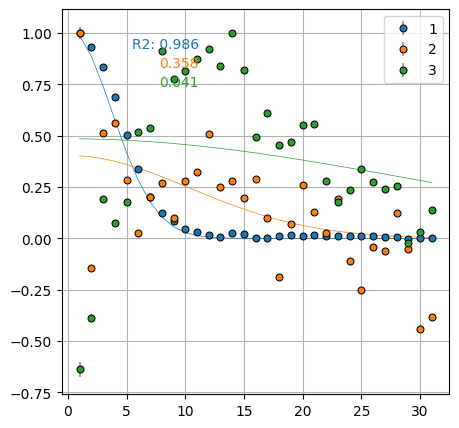

In [7]:
labels = ['1', '2', '3']
draw_profiles(profiles, labels, fit='all')

In [145]:
# xs = []
# ys = []

# colors = list(mcolors.TABLEAU_COLORS)

# xys = np.loadtxt('M82_ps_cat.txt')

# df = pd.DataFrame(xys)
# df1 = df.loc[(df.loc[:, 0] >0) & (df.loc[:, 0] < 1080)]
# df2 = df1.loc[(df1.loc[:, 1] >0) & (df1.loc[:, 1] < 1080)]
# xys = df2.to_numpy()

# for i in range(25000):
#     x, y = 1080 * np.random.random(2)
    
#     if ((M82_ellipse(x, y)) and (min_dist(x, y, xys) > 17) and (dop_condition(x, y))):
#         xs.append(x)
#         ys.append(y)

# vmin, vmax = get_contrast(sci_d, contrast=0.1)
# fig, ax = plt.subplots(figsize=(12, 12))

# ax.imshow(sci_d, vmin=vmin, vmax=vmax, cmap='gray', origin='upper')

# ax.scatter(xs, ys,
#            s=17,
#            color=colors[1],
#            edgecolor='k',
#            linewidth=.75,
#            label='Simulated transients')

# ax.scatter(xys[:, 0], xys[:, 1], 
#            color=colors[0], 
#            s=17, 
#            edgecolor='k',
#            linewidth=.75,
#            label='PS1 catalog objects')

# ax.legend(fontsize=20, loc ="upper left", markerscale=5)

# plt.savefig('simulations.png')

In [ ]:
net = define_G(n_layers_G=config.N_LAYERS_G,
               ngf=4,
               kernel=config.KERNEL,
               skip=config.SKIP,
               upsample_mode=config.UPSAMPLE_MODE)

dict_name = str(config.UPSAMPLE_MODE) + '_skip_' + str(config.SKIP) + '_' + str(config.N_LAYERS_G) + '_' + str(config.KERNEL)
load = 'state_dicts/' + dict_name + '.pth'
torch.save(net.state_dict(), load)